In [2]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import geopandas as gpd


In [3]:

pytrends = TrendReq(hl='fr-FR', tz=360)

In [4]:
keywords_bio = [
    "agriculture bio", 
    "manger bio", 
]


In [5]:
keywords_pesticides = [
    "pesticides",  
    "qualité de l'eau", 
]


In [6]:
# Dictionnaire pour stocker les résultats
results_by_keyword = {}

for keyword in keywords_bio:
    try:
        # Construire la requête pour le mot-clé
        pytrends.build_payload([keyword], geo='FR', timeframe='2022-01-01 2022-12-31')
        
        # Pause pour éviter les limitations de Google Trends
        time.sleep(120)
        
        # Obtenir les données par région
        data = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True)
        
        # Transformer les données en dictionnaire
        regional_data = data[keyword].to_dict()  # 'keyword' est le nom de la colonne des valeurs
        
        # Ajouter au dictionnaire global
        results_by_keyword[keyword] = regional_data
        
        print(f"Résultats pour '{keyword}' récupérés avec succès.")
    
    except Exception as e:
        print(f"Erreur avec le mot-clé '{keyword}': {e}")

# Afficher le dictionnaire des résultats
print(results_by_keyword)

Résultats pour 'agriculture bio' récupérés avec succès.
Résultats pour 'manger bio' récupérés avec succès.
{'agriculture bio': {'Alsace': 28, 'Aquitaine': 47, 'Auvergne': 42, 'Basse-Normandie': 31, 'Bourgogne': 53, 'Bretagne': 68, 'Centre-Val de Loire': 41, 'Champagne-Ardenne': 50, 'Corse': 69, 'Franche-Comté': 42, 'Haute-Normandie': 32, 'Languedoc-Roussillon': 55, 'Limousin': 100, 'Lorraine': 38, 'Midi-Pyrénées': 76, 'Nord-Pas-de-Calais': 32, 'Pays de la Loire': 62, 'Picardie': 39, 'Poitou-Charentes': 55, "Provence-Alpes-Côte d'Azur": 39, 'Rhône-Alpes': 40, 'Île-de-France': 36}, 'manger bio': {'Alsace': 68, 'Aquitaine': 91, 'Auvergne': 75, 'Basse-Normandie': 78, 'Bourgogne': 62, 'Bretagne': 92, 'Centre-Val de Loire': 67, 'Champagne-Ardenne': 36, 'Corse': 0, 'Franche-Comté': 70, 'Haute-Normandie': 52, 'Languedoc-Roussillon': 47, 'Limousin': 85, 'Lorraine': 43, 'Midi-Pyrénées': 68, 'Nord-Pas-de-Calais': 58, 'Pays de la Loire': 100, 'Picardie': 41, 'Poitou-Charentes': 52, "Provence-Alpes

<Figure size 1000x1000 with 0 Axes>

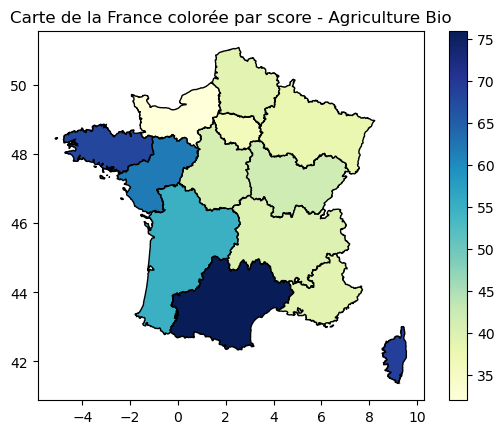

<Figure size 1000x1000 with 0 Axes>

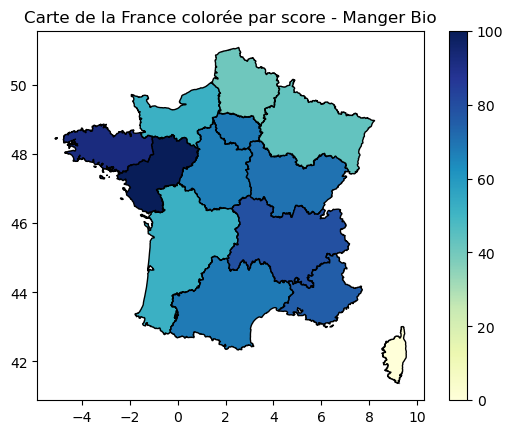

In [7]:
# Correspondance entre anciennes et nouvelles régions
mapping = {
    'Alsace': 'Grand Est',
    'Aquitaine': 'Nouvelle-Aquitaine',
    'Auvergne': 'Auvergne-Rhône-Alpes',
    'Basse-Normandie': 'Normandie',
    'Bourgogne': 'Bourgogne-Franche-Comté',
    'Bretagne': 'Bretagne',
    'Centre-Val de Loire': 'Centre-Val de Loire',
    'Champagne-Ardenne': 'Grand Est',
    'Corse': 'Corse',
    'Franche-Comté': 'Bourgogne-Franche-Comté',
    'Haute-Normandie': 'Normandie',
    'Languedoc-Roussillon': 'Occitanie',
    'Limousin': 'Nouvelle-Aquitaine',
    'Lorraine': 'Grand Est',
    'Midi-Pyrénées': 'Occitanie',
    'Nord-Pas-de-Calais': 'Hauts-de-France',
    'Pays de la Loire': 'Pays de la Loire',
    'Picardie': 'Hauts-de-France',
    'Poitou-Charentes': 'Nouvelle-Aquitaine',
    "Provence-Alpes-Côte d'Azur": "Provence-Alpes-Côte d'Azur",
    'Rhône-Alpes': 'Auvergne-Rhône-Alpes',
    'Île-de-France': 'Île-de-France'
}

# Convertir les résultats en données correspondantes aux régions mappées
mapped_regions_data_agriculture = [(mapping.get(region, region), score) for region, score in results_by_keyword['agriculture bio'].items()]
mapped_regions_data_manger = [(mapping.get(region, region), score) for region, score in results_by_keyword['manger bio'].items()]

# Charger les données géographiques des régions françaises depuis GeoJSON
geojson_url = "https://france-geojson.gregoiredavid.fr/repo/regions.geojson"
regions_map = gpd.read_file(geojson_url)

# Ajouter les scores aux données géographiques pour chaque mot-clé
scores_dict_agriculture = dict(mapped_regions_data_agriculture)
scores_dict_manger = dict(mapped_regions_data_manger)

regions_map["score_agriculture"] = regions_map["nom"].map(scores_dict_agriculture)
regions_map["score_manger"] = regions_map["nom"].map(scores_dict_manger)

# Filtrer les régions sans score (Guadeloupe, Martinique, Guyane, La Réunion, Mayotte)
regions_map_filtered_agriculture = regions_map[regions_map["score_agriculture"].notna()]
regions_map_filtered_manger = regions_map[regions_map["score_manger"].notna()]

# Ajuster l'échelle des couleurs en fonction des valeurs de score pour chaque carte
min_score_agriculture = regions_map_filtered_agriculture["score_agriculture"].min()
max_score_agriculture = regions_map_filtered_agriculture["score_agriculture"].max()

min_score_manger = regions_map_filtered_manger["score_manger"].min()
max_score_manger = regions_map_filtered_manger["score_manger"].max()

# Visualisation de la carte pour "agriculture bio"
plt.figure(figsize=(10, 10))
regions_map_filtered_agriculture.plot(
    column="score_agriculture", 
    cmap="YlGnBu", 
    legend=True, 
    edgecolor="black", 
    missing_kwds={"color": "lightgrey"},
    vmin=min_score_agriculture,  # Valeur minimale pour l'échelle des couleurs
    vmax=max_score_agriculture   # Valeur maximale pour l'échelle des couleurs
)
plt.title("Carte de la France colorée par score - Agriculture Bio")
plt.show()

# Visualisation de la carte pour "manger bio"
plt.figure(figsize=(10, 10))
regions_map_filtered_manger.plot(
    column="score_manger", 
    cmap="YlGnBu", 
    legend=True, 
    edgecolor="black", 
    missing_kwds={"color": "lightgrey"},
    vmin=min_score_manger,  # Valeur minimale pour l'échelle des couleurs
    vmax=max_score_manger   # Valeur maximale pour l'échelle des couleurs
)
plt.title("Carte de la France colorée par score - Manger Bio")
plt.show()


In [8]:
# Initialiser PyTrends
pytrends = TrendReq(hl='fr-FR', tz=360)


# Dictionnaire pour stocker les résultats par mot-clé
results_by_keyword_p = {}

for keyword in keywords_pesticides:
    try:
        # Construire la requête pour chaque mot-clé
        pytrends.build_payload([keyword], geo='FR', timeframe='2022-01-01 2022-12-31')
        
        # Pause pour éviter les limitations de Google Trends
        time.sleep(120)
        
        # Obtenir les données par région
        data = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True)
        
        # Transformer les données en dictionnaire pour chaque mot-clé
        regional_data = data[keyword].to_dict()  # Le mot-clé est le nom de la colonne des valeurs
        
        # Ajouter les résultats au dictionnaire global
        results_by_keyword_p[keyword] = regional_data
        
        print(f"Résultats pour '{keyword}' récupérés avec succès.")
    
    except Exception as e:
        print(f"Erreur avec le mot-clé '{keyword}': {e}")

# Afficher le dictionnaire des résultats
print(results_by_keyword_p)

Résultats pour 'pesticides' récupérés avec succès.
Résultats pour 'qualité de l'eau' récupérés avec succès.
{'pesticides': {'Alsace': 75, 'Aquitaine': 82, 'Auvergne': 68, 'Basse-Normandie': 72, 'Bourgogne': 71, 'Bretagne': 100, 'Centre-Val de Loire': 72, 'Champagne-Ardenne': 73, 'Corse': 59, 'Franche-Comté': 65, 'Haute-Normandie': 61, 'Languedoc-Roussillon': 90, 'Limousin': 71, 'Lorraine': 71, 'Midi-Pyrénées': 89, 'Nord-Pas-de-Calais': 69, 'Pays de la Loire': 81, 'Picardie': 79, 'Poitou-Charentes': 98, "Provence-Alpes-Côte d'Azur": 68, 'Rhône-Alpes': 71, 'Île-de-France': 74}, "qualité de l'eau": {'Alsace': 90, 'Aquitaine': 63, 'Auvergne': 80, 'Basse-Normandie': 65, 'Bourgogne': 84, 'Bretagne': 81, 'Centre-Val de Loire': 90, 'Champagne-Ardenne': 68, 'Corse': 99, 'Franche-Comté': 83, 'Haute-Normandie': 54, 'Languedoc-Roussillon': 92, 'Limousin': 100, 'Lorraine': 62, 'Midi-Pyrénées': 68, 'Nord-Pas-de-Calais': 68, 'Pays de la Loire': 73, 'Picardie': 71, 'Poitou-Charentes': 82, "Provence-Al

<Figure size 1000x1000 with 0 Axes>

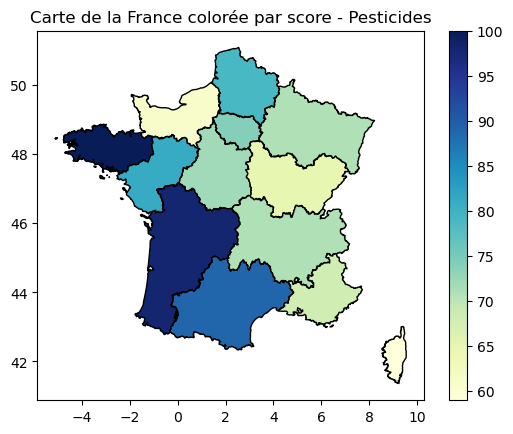

<Figure size 1000x1000 with 0 Axes>

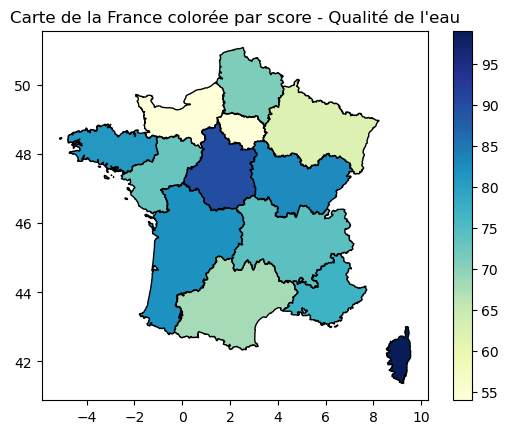

In [9]:
# Convertir les résultats en données correspondantes aux régions mappées
mapped_regions_data_pesticides = [(mapping.get(region, region), score) for region, score in results_by_keyword_p['pesticides'].items()]
mapped_regions_data_qualite_eau = [(mapping.get(region, region), score) for region, score in results_by_keyword_p['qualité de l\'eau'].items()]

# Charger les données géographiques des régions françaises depuis GeoJSON
geojson_url = "https://france-geojson.gregoiredavid.fr/repo/regions.geojson"
regions_map = gpd.read_file(geojson_url)

# Ajouter les scores aux données géographiques pour chaque mot-clé
scores_dict_pesticides = dict(mapped_regions_data_pesticides)
scores_dict_qualite_eau = dict(mapped_regions_data_qualite_eau)

regions_map["score_pesticides"] = regions_map["nom"].map(scores_dict_pesticides)
regions_map["score_qualite_eau"] = regions_map["nom"].map(scores_dict_qualite_eau)

# Filtrer les régions sans score (par exemple, Guadeloupe, Martinique, Guyane, La Réunion, Mayotte)
regions_map_filtered_pesticides = regions_map[regions_map["score_pesticides"].notna()]
regions_map_filtered_qualite_eau = regions_map[regions_map["score_qualite_eau"].notna()]

# Ajuster l'échelle des couleurs en fonction des valeurs de score pour chaque carte
min_score_pesticides = regions_map_filtered_pesticides["score_pesticides"].min()
max_score_pesticides = regions_map_filtered_pesticides["score_pesticides"].max()

min_score_qualite_eau = regions_map_filtered_qualite_eau["score_qualite_eau"].min()
max_score_qualite_eau = regions_map_filtered_qualite_eau["score_qualite_eau"].max()

# Visualisation de la carte pour "pesticides"
plt.figure(figsize=(10, 10))
regions_map_filtered_pesticides.plot(
    column="score_pesticides", 
    cmap="YlGnBu", 
    legend=True, 
    edgecolor="black", 
    missing_kwds={"color": "lightgrey"},
    vmin=min_score_pesticides,  # Valeur minimale pour l'échelle des couleurs
    vmax=max_score_pesticides   # Valeur maximale pour l'échelle des couleurs
)
plt.title("Carte de la France colorée par score - Pesticides")
plt.show()

# Visualisation de la carte pour "qualité de l'eau"
plt.figure(figsize=(10, 10))
regions_map_filtered_qualite_eau.plot(
    column="score_qualite_eau", 
    cmap="YlGnBu", 
    legend=True, 
    edgecolor="black", 
    missing_kwds={"color": "lightgrey"},
    vmin=min_score_qualite_eau,  # Valeur minimale pour l'échelle des couleurs
    vmax=max_score_qualite_eau   # Valeur maximale pour l'échelle des couleurs
)
plt.title("Carte de la France colorée par score - Qualité de l'eau")
plt.show()


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Les données pour 'agriculture bio' ont été récupérées avec succès.


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Les données pour 'manger bio' ont été récupérées avec succès.


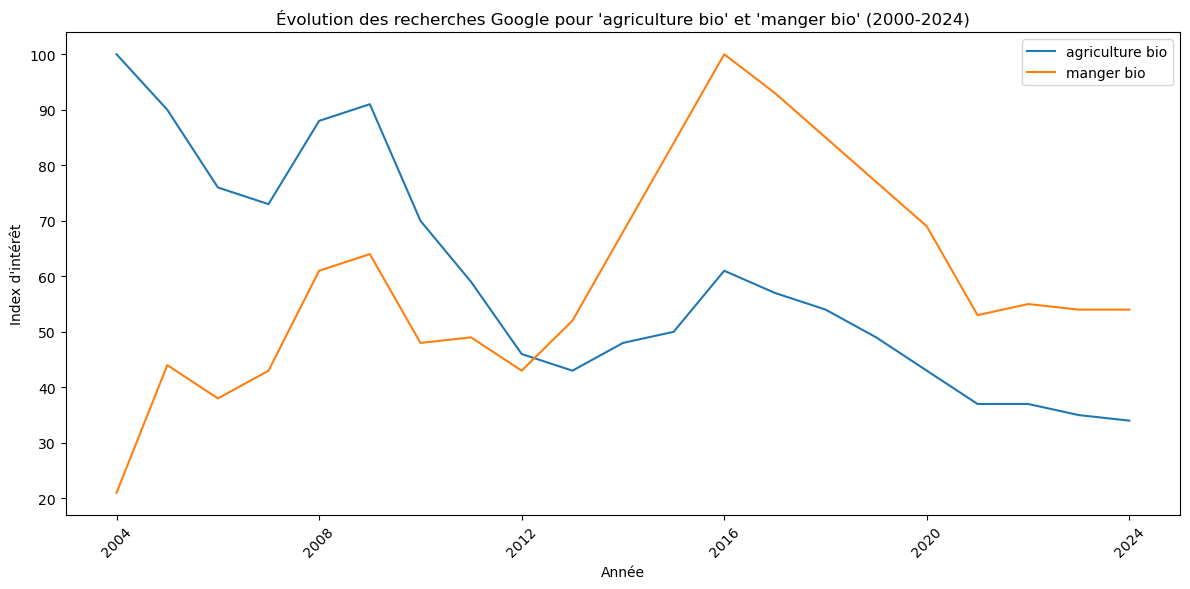

In [6]:
# Initialiser PyTrends
pytrends = TrendReq(hl='fr-FR', tz=360)

# Liste des mots-clés
keywords_bio = ["agriculture bio", "manger bio"]

# Définir la période de temps (2000-2024)
start_date = '2000-01-01'
end_date = '2024-12-31'

# Créer un dictionnaire pour stocker les résultats
trend_data = {}

# Récupérer les données de Google Trends pour chaque mot-clé
for keyword in keywords_bio:
    try:
        # Construire la requête pour le mot-clé
        pytrends.build_payload([keyword], geo='FR', timeframe=f'{start_date} {end_date}')
        
        # Récupérer les données d'intérêt au fil du temps
        data = pytrends.interest_over_time()
        
        # Ajouter les résultats dans le dictionnaire
        trend_data[keyword] = data[keyword]
        
        # Pause pour éviter les limitations de Google Trends
        time.sleep(60)
        
        print(f"Les données pour '{keyword}' ont été récupérées avec succès.")
    except Exception as e:
        print(f"Erreur pour le mot-clé '{keyword}': {e}")

# Créer le graphique
plt.figure(figsize=(12, 6))

# Tracer les courbes pour chaque mot-clé
for keyword in keywords_bio:
    plt.plot(trend_data[keyword].index, trend_data[keyword], label=keyword)

# Ajouter les labels et la légende
plt.title("Évolution des recherches Google pour 'agriculture bio' et 'manger bio' (2000-2024)")
plt.xlabel("Année")
plt.ylabel("Index d'intérêt")
plt.legend()

# Afficher le graphique
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Les données pour 'pesticides' ont été récupérées avec succès.


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Les données pour 'qualité de l'eau' ont été récupérées avec succès.


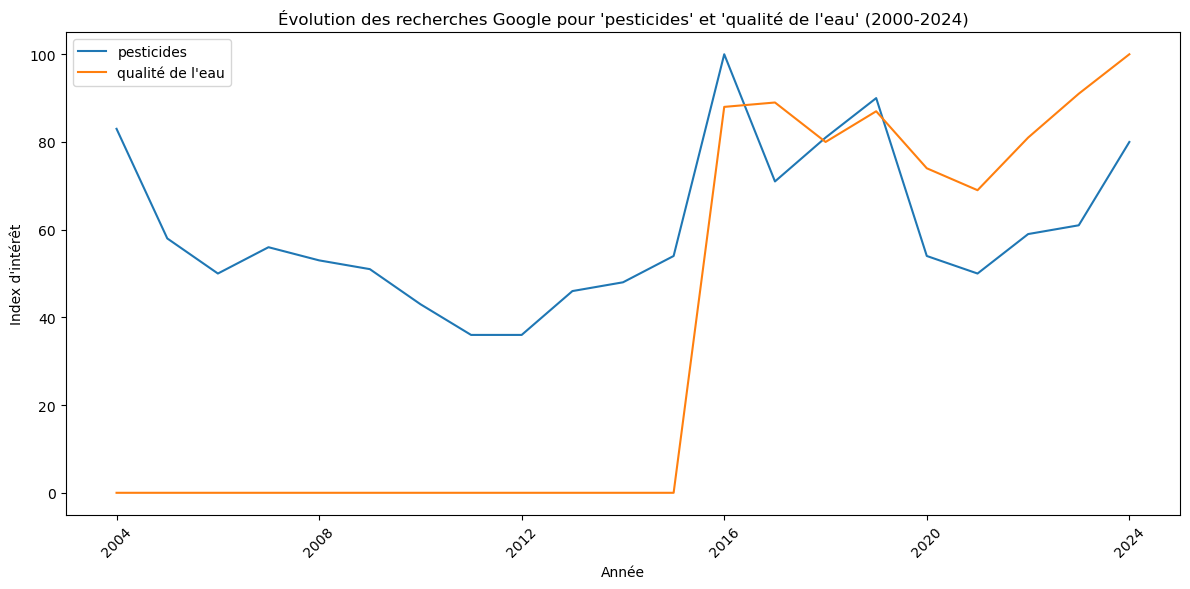

In [8]:
# Initialiser PyTrends
pytrends = TrendReq(hl='fr-FR', tz=360)

# Liste des mots-clés
keywords_pesticides = ["pesticides", "qualité de l'eau"]

# Définir la période de temps (2000-2024)
start_date = '2000-01-01'
end_date = '2024-12-31'

# Créer un dictionnaire pour stocker les résultats
trend_data = {}

# Récupérer les données de Google Trends pour chaque mot-clé
for keyword in keywords_pesticides:
    try:
        # Construire la requête pour le mot-clé
        pytrends.build_payload([keyword], geo='FR', timeframe=f'{start_date} {end_date}')
        
        # Récupérer les données d'intérêt au fil du temps
        data = pytrends.interest_over_time()
        
        # Ajouter les résultats dans le dictionnaire
        trend_data[keyword] = data[keyword]
        
        # Pause pour éviter les limitations de Google Trends
        time.sleep(60)
        
        print(f"Les données pour '{keyword}' ont été récupérées avec succès.")
    except Exception as e:
        print(f"Erreur pour le mot-clé '{keyword}': {e}")

# Créer le graphique
plt.figure(figsize=(12, 6))

# Tracer les courbes pour chaque mot-clé
for keyword in keywords_pesticides:
    plt.plot(trend_data[keyword].index, trend_data[keyword], label=keyword)

# Ajouter les labels et la légende
plt.title("Évolution des recherches Google pour 'pesticides' et 'qualité de l'eau' (2000-2024)")
plt.xlabel("Année")
plt.ylabel("Index d'intérêt")
plt.legend()

# Afficher le graphique
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


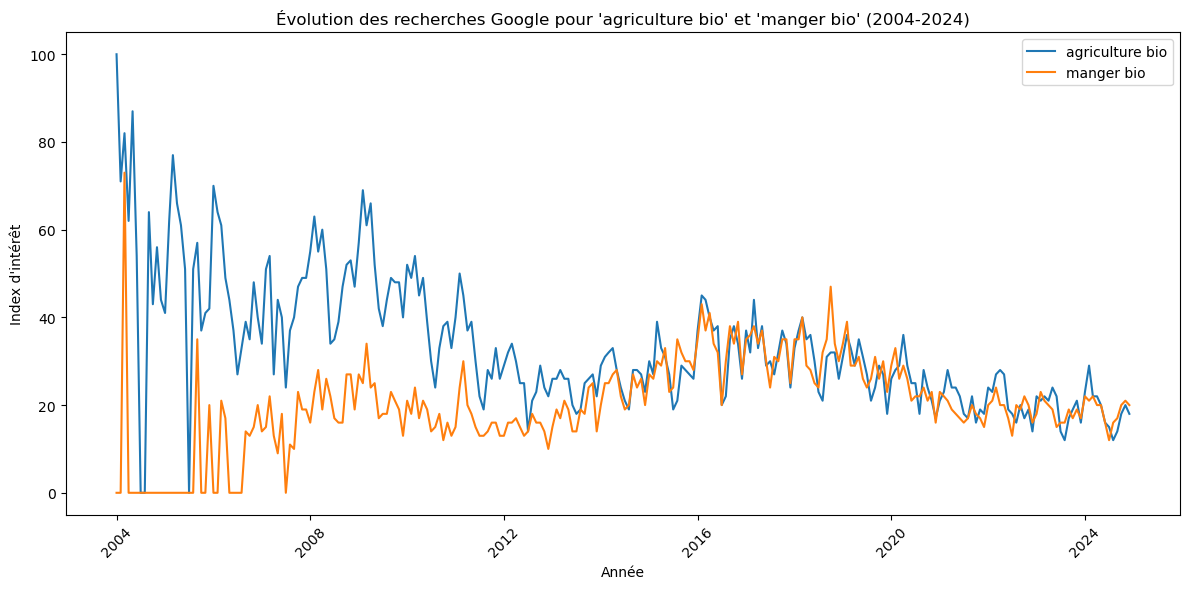

In [5]:
pytrends = TrendReq(hl='fr-FR', tz=360)

# Liste des mots-clés
keywords_bio = ["agriculture bio", "manger bio"]

# Définir la période de temps (2000-2024)
start_date = '2004-01-01'  # Google Trends commence en 2004
end_date = '2024-12-31'

# Construire la requête pour tous les mots-clés en même temps
try:
    pytrends.build_payload(keywords_bio, geo='FR', timeframe=f'{start_date} {end_date}')
    
    # Récupérer les données d'intérêt au fil du temps
    data = pytrends.interest_over_time()

    # Vérifier que les données contiennent des résultats valides
    if data.empty:
        print("Aucune donnée disponible pour les mots-clés fournis.")
    else:
        # Créer le graphique
        plt.figure(figsize=(12, 6))

        # Tracer les courbes pour chaque mot-clé
        for keyword in keywords_bio:
            plt.plot(data.index, data[keyword], label=keyword)

        # Ajouter les labels et la légende
        plt.title("Évolution des recherches Google pour 'agriculture bio' et 'manger bio' (2004-2024)")
        plt.xlabel("Année")
        plt.ylabel("Index d'intérêt")
        plt.legend()

        # Afficher le graphique
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Erreur lors de la récupération des données : {e}")


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


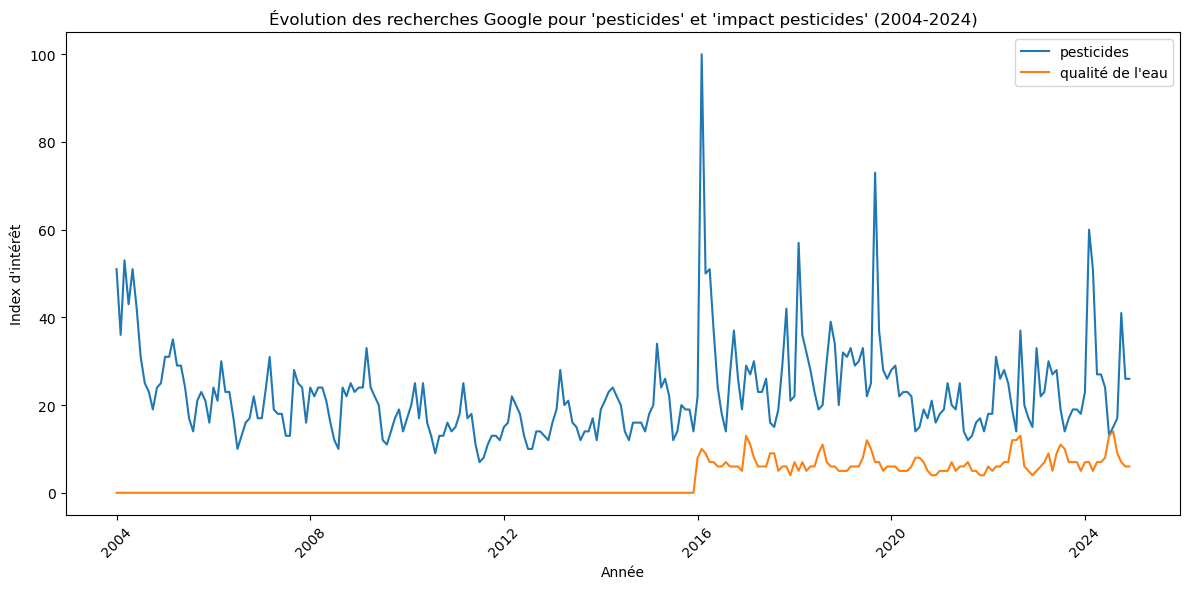

In [ ]:
# Initialiser PyTrends
pytrends = TrendReq(hl='fr-FR', tz=360)

# Définir la période de temps (2004-2024, car Google Trends commence en 2004)
start_date = '2004-01-01'
end_date = '2024-12-31'

# Construire la requête pour tous les mots-clés en même temps
try:
    pytrends.build_payload(keywords_pesticides, geo='FR', timeframe=f'{start_date} {end_date}')
    
    # Récupérer les données d'intérêt au fil du temps
    data = pytrends.interest_over_time()

    # Vérifier que les données contiennent des résultats valides
    if data.empty:
        print("Aucune donnée disponible pour les mots-clés fournis.")
    else:
        # Créer le graphique
        plt.figure(figsize=(12, 6))

        # Tracer les courbes pour chaque mot-clé
        for keyword in keywords_pesticides:
            plt.plot(data.index, data[keyword], label=keyword)

        # Ajouter les labels et la légende
        plt.title("Évolution des recherches Google pour 'pesticides' et 'qualité de l'eau ' (2004-2024)")
        plt.xlabel("Année")
        plt.ylabel("Index d'intérêt")
        plt.legend()

        # Afficher le graphique
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Erreur lors de la récupération des données : {e}")


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


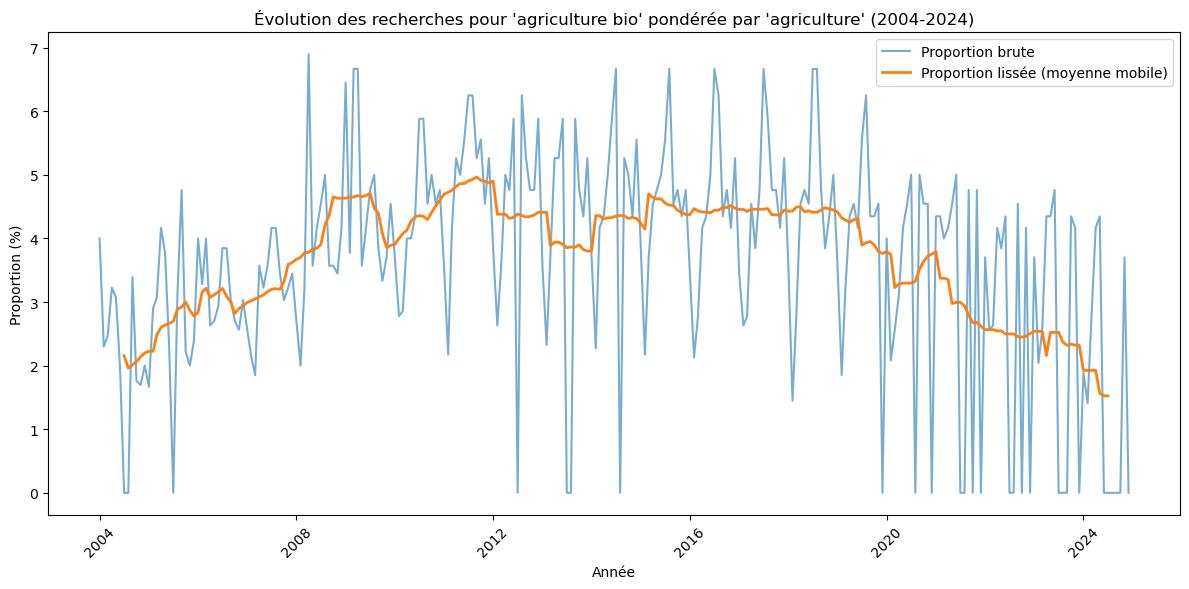

In [15]:
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import pandas as pd

# Initialiser PyTrends
pytrends = TrendReq(hl='fr-FR', tz=360)

# Liste des mots-clés
keywords = ["agriculture bio", "agriculture"]

# Définir la période de temps (2004-2024, car Google Trends commence en 2004)
start_date = '2004-01-01'
end_date = '2024-12-31'

# Construire la requête pour les mots-clés
try:
    pytrends.build_payload(keywords, geo='FR', timeframe=f'{start_date} {end_date}')
    
    # Récupérer les données d'intérêt au fil du temps
    data = pytrends.interest_over_time()

    # Vérifier que les données contiennent des résultats valides
    if data.empty:
        print("Aucune donnée disponible pour les mots-clés fournis.")
    else:
        # Calculer le ratio (agriculture bio / agriculture) * 100
        data['ratio'] = (data['agriculture bio'] / data['agriculture']) * 100

        # Appliquer un lissage avec une moyenne mobile (fenêtre de 12 mois)
        data['smoothed_ratio'] = data['ratio'].rolling(window=12, center=True).mean()

        # Créer le graphique
        plt.figure(figsize=(12, 6))

        # Tracer le ratio brut
        plt.plot(data.index, data['ratio'], label="Proportion brute", alpha=0.6)

        # Tracer le ratio lissé
        plt.plot(data.index, data['smoothed_ratio'], label="Proportion lissée (moyenne mobile)", linewidth=2)

        # Ajouter les labels et la légende
        plt.title("Évolution des recherches pour 'agriculture bio' pondérée par 'agriculture' (2004-2024)")
        plt.xlabel("Année")
        plt.ylabel("Proportion (%)")
        plt.legend()

        # Afficher le graphique
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Erreur lors de la récupération des données : {e}")


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Mois avec des pics détectés dans la courbe lissée :
['2005-10', '2006-03', '2006-07', '2007-08', '2008-10', '2009-04', '2009-07', '2010-07', '2011-09', '2012-01', '2012-07', '2013-08', '2013-10', '2014-08', '2014-11', '2015-03', '2016-02', '2016-11', '2017-08', '2017-12', '2018-06', '2018-10', '2019-06', '2019-09', '2020-01', '2020-05', '2021-01', '2023-10', '2023-12']


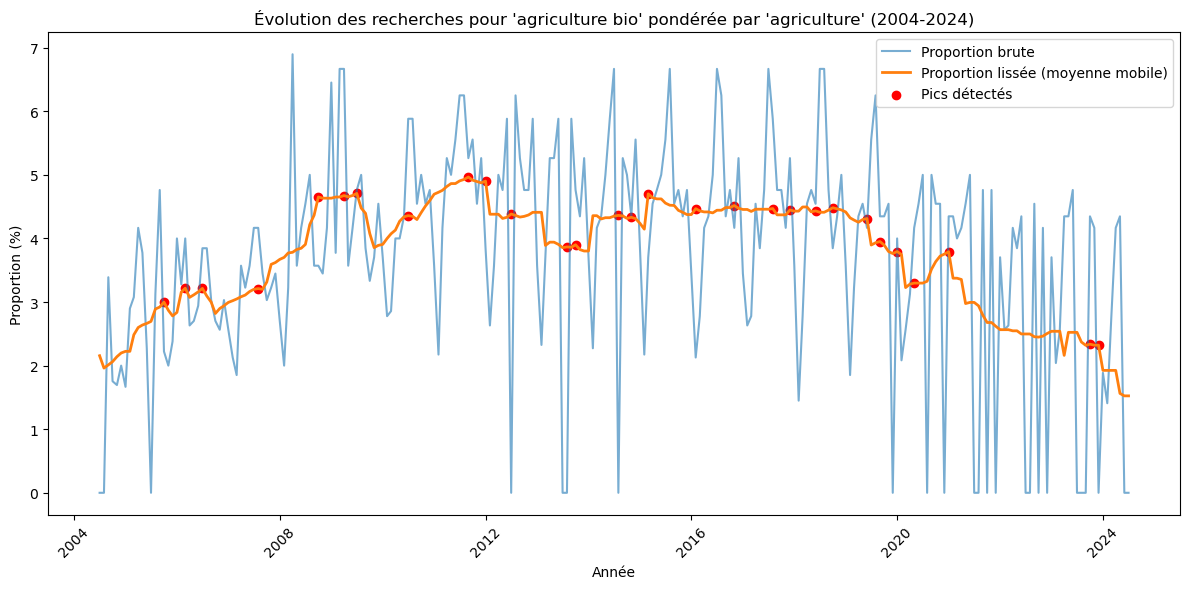

In [16]:
from scipy.signal import argrelextrema

# Initialiser PyTrends
pytrends = TrendReq(hl='fr-FR', tz=360)

# Liste des mots-clés
keywords = ["agriculture bio", "agriculture"]

# Définir la période de temps (2004-2024, car Google Trends commence en 2004)
start_date = '2004-01-01'
end_date = '2024-12-31'

# Construire la requête pour les mots-clés
try:
    pytrends.build_payload(keywords, geo='FR', timeframe=f'{start_date} {end_date}')
    
    # Récupérer les données d'intérêt au fil du temps
    data = pytrends.interest_over_time()

    # Vérifier que les données contiennent des résultats valides
    if data.empty:
        print("Aucune donnée disponible pour les mots-clés fournis.")
    else:
        # Calculer le ratio (agriculture bio / agriculture) * 100
        data['ratio'] = (data['agriculture bio'] / data['agriculture']) * 100

        # Appliquer un lissage avec une moyenne mobile (fenêtre de 12 mois)
        data['smoothed_ratio'] = data['ratio'].rolling(window=12, center=True).mean()

        # Identifier les pics locaux (maxima) dans la courbe lissée
        data = data.dropna()  # Supprimer les valeurs NaN après le lissage
        peaks_indices = argrelextrema(data['smoothed_ratio'].values, comparator=lambda x, y: x > y)[0]
        peaks_months = data.iloc[peaks_indices].index.strftime('%Y-%m').tolist()

        print("Mois avec des pics détectés dans la courbe lissée :")
        print(peaks_months)

        # Créer le graphique
        plt.figure(figsize=(12, 6))

        # Tracer le ratio brut
        plt.plot(data.index, data['ratio'], label="Proportion brute", alpha=0.6)

        # Tracer le ratio lissé
        plt.plot(data.index, data['smoothed_ratio'], label="Proportion lissée (moyenne mobile)", linewidth=2)

        # Mettre en évidence les pics détectés
        plt.scatter(data.iloc[peaks_indices].index, data.iloc[peaks_indices]['smoothed_ratio'], color='red', label="Pics détectés")

        # Ajouter les labels et la légende
        plt.title("Évolution des recherches pour 'agriculture bio' pondérée par 'agriculture' (2004-2024)")
        plt.xlabel("Année")
        plt.ylabel("Proportion (%)")
        plt.legend()

        # Afficher le graphique
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Erreur lors de la récupération des données : {e}")
